In [490]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup as bs

In [491]:
# Functions that are used throughout the project 
def call_data(name,columns_dropped):

#Reading the documento CSV
    db = pd.read_csv(name)

# Drop the columns which are gonna be unecessary to the analysis
    db.drop(db.columns[columns_dropped],axis=1,inplace=True)
    return db

In [492]:
#Function to drop duplicates and NaN
def drop_clean_table(name_table,columns_to_drop_duplicate,columns_to_drop_NaN):
    name_table.drop_duplicates(subset = columns_to_drop_duplicate, inplace=True)

#Drop NaN values which is not interesting for me 
    name_table.dropna(subset = columns_to_drop_NaN,inplace=True)
    return name_table

In [493]:
# Using the function to set the table and get it ready to work with 
order_date = call_data("olist_orders_dataset.csv",[1,3,4,7])

In [494]:
# Subsetting for deliveries completed 
order_date = order_date[order_date["order_status"]=="delivered"]

# Disconsider rows which there is no products departure and arrival dates (Difference: from 96478 to 96469)
order_date.dropna(subset=['order_delivered_carrier_date', 'order_delivered_customer_date'],inplace=True)

In [495]:
#Converting the dates columns into Series(datetimes type) and subtracting them 
date_departure = pd.to_datetime(order_date["order_delivered_carrier_date"])
date_arrival = pd.to_datetime(order_date["order_delivered_customer_date"])
time_delay = (date_arrival - date_departure) / np.timedelta64(1,"D")

In [496]:
# Merge the Series into DataFrame back
date_merged = order_date.merge(time_delay.rename("Delivery Delay"),left_index=True,right_index=True)

In [497]:
#Set index to merge with the other DF(seller_order) which there is the same data columns 
date_merged.set_index("order_id",inplace=True)

In [498]:
# Using the function to set the table and get it ready to work with 
seller_state = call_data("olist_sellers_dataset.csv",[1])

In [499]:
# Verifying if there is no duplicates or NaN by the function
seller_state =drop_clean_table(seller_state,["seller_id"],["seller_id","seller_state"])

In [500]:
#Set index to merge with the other DF(seller_order) which there is the same data columns 
seller_state.set_index("seller_id",inplace=True)

In [501]:
# Using the function to call the DF
seller_order = call_data("olist_order_items_dataset.csv",[1,2,4,5,6])

In [502]:
# Using the function to clean the DF
seller_order =drop_clean_table(seller_order,["order_id","seller_id"],["order_id","seller_id"])

In [503]:
# Set index to merge with the other DF(seller_state) which there is the same data columns 
seller_order.set_index("seller_id",inplace=True)

In [504]:
# Merge the 2 DFs to get the relation between the order and where its departuring 
seller_order = seller_order.merge(seller_state,left_index=True,right_index=True)

In [505]:
#Set index to merge with the other DF(date_merged) which there is the same data columns 
seller_order.set_index("order_id",inplace=True)

In [506]:
# Merge 2 DFs with the same idea as the last one
place_time = date_merged.merge(seller_order,left_index=True,right_index=True)

In [507]:
#Counting the number of orders for each state
delay_orders = place_time.groupby(["seller_state"])["Delivery Delay"].agg(np.mean)
num_orders_place = place_time.groupby(["seller_state"]).count()

In [508]:
# Prepare the DF to merge to another 
num_orders_place.drop(num_orders_place.columns[[1,2,3,4]],axis=1,inplace=True)

# Merge the Series into the DF to get all the info that i need in one table 
delay_orders_delivery = pd.concat([num_orders_place,delay_orders],axis=1)

In [509]:
# Name the columns
delay_orders_delivery.columns = ["Delivery Orders","Delivery Delay(Days)"]

In [510]:
# Sort the values in order to set the table ready to show
delay_orders_delivery = delay_orders_delivery.sort_values(by = ["Delivery Delay(Days)","Delivery Orders"], ascending= [True,False])

In [511]:
# Access the information fo the website =(all the objects)
gdp = requests.get('https://www.ibge.gov.br/explica/pib.php')

# Using the beautifulsoup method to get just the information readable 
gdp_brazil = bs(gdp.content, 'lxml')

# Finding the table needed on this html
table = gdp_brazil.find("table")

# Transforming the html information into a pandas table to get ready to work with it 
gdp_df = pd.read_html(str(table))[0]

In [512]:
# Create empty lists and variables to apply the interaction method 
list_gdp=[]
list_states=[]
gdp_v=0

# Apply the interaction method "while" in order to create lists and then, a DataFrame
while gdp_v<=len(gdp_df.index)-1:
    number = gdp_df.iloc[gdp_v][1].replace(".","")
    list_gdp.append(int(number))
    list_states.append(str(gdp_df.iloc[gdp_v][0]))
    gdp_v=gdp_v+1

In [513]:
# Creating a DataFrame based on the lists created before
gdp_new_df = pd.DataFrame(list(zip(list_states, list_gdp)),columns =['States', 'GDP in 2019 (1.000.000 R$)'])

In [514]:
# Sort the values 
gdp_new_df.sort_values(by = "GDP in 2019 (1.000.000 R$)", ascending = False,inplace=True)

# Set the index to get ready to merge
gdp_new_df.set_index("States",inplace=True)

In [515]:
# Access the information fo the website =(all the objects)
states = requests.get('https://mundoeducacao.uol.com.br/geografia/estados-brasil.htm')

# Using the beautifulsoup method to get just the information readable 
states_brazil = bs(states.content, 'lxml')

# Finding the table needed on this html
table = states_brazil.find("table")

# Transforming the html information into a pandas table to get ready to work with it 
states_df = pd.read_html(str(table))[0]

In [516]:
# Fix the table indexes 
states_df=states_df[1:]

# Name the columns
states_df.columns = ["States","Abbreviations"]

In [517]:
#Set index to merge with the other DF(date_merged) which there is the same data columns 
states_df.set_index("States",inplace=True)

In [518]:
# Merge the two DFs to get the GDP per state and the abbreviation included 
states_gdp_abb = states_df.merge(gdp_new_df,left_index=True,right_index=True,how="left")
states_gdp_abb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, Acre to Distrito Federal
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Abbreviations               27 non-null     object
 1   GDP in 2019 (1.000.000 R$)  27 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [519]:
# Reset index to get prepared for the next merge
states_gdp_abb.reset_index(inplace=True)

# Set the index for the next merge(Combine both indexes)
states_gdp_abb.set_index("Abbreviations",inplace=True)

In [520]:
# Merge the delivery orders info with the states GDP info 
states_gdp_abb_deli = delay_orders_delivery.merge(states_gdp_abb,left_index=True,right_index=True,how="left")

In [521]:
# Reset the index and tidy the columns up
states_gdp_abb_deli.reset_index(inplace=True)
states_gdp_abb_deli = states_gdp_abb_deli[["States","seller_state","Delivery Orders","Delivery Delay(Days)","GDP in 2019 (1.000.000 R$)"]]

In [522]:
# Name the columns
states_gdp_abb_deli.columns = ["States","Abbreviations","Delivery Orders","Delivery Delay(Days)","GDP in 2019 (1.000.000 R$)"]

In [523]:
# Set the index for plotting
states_gdp_abb_deli.set_index("States",inplace=True)
print(states_gdp_abb_deli)

                    Abbreviations  Delivery Orders  Delivery Delay(Days)  \
States                                                                     
Rio Grande do Sul              RS             1964              8.064388   
Mato Grosso do Sul             MS               49              8.098366   
Rio Grande do Norte            RN               51              8.716393   
São Paulo                      SP            69395              9.095651   
Rio de Janeiro                 RJ             4229              9.225426   
Paraíba                        PB               35              9.371992   
Distrito Federal               DF              808              9.519663   
Minas Gerais                   MG             7745              9.621394   
Paraná                         PR             7555              9.938253   
Pará                           PA                8              9.954369   
Sergipe                        SE                9             10.292127   
Goiás       

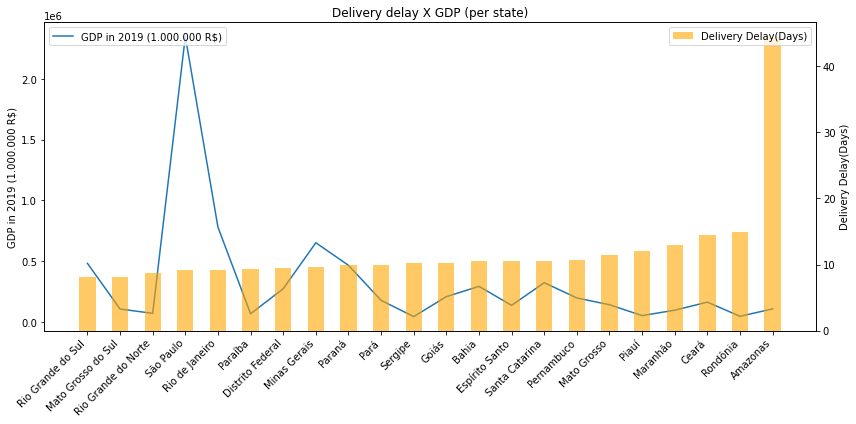

In [524]:
# Applying the method to make possible to plot two info at the same chart 
fig, ax1 = plt.subplots()

# PLotting the chart 5(info1) which is the GDP per states
ax1.plot(states_gdp_abb_deli.index,states_gdp_abb_deli["GDP in 2019 (1.000.000 R$)"])

# Set label
ax1.set_ylabel('GDP in 2019 (1.000.000 R$)')

# Set legend
ax1.legend(['GDP in 2019 (1.000.000 R$)'], loc="upper left")

# Make both plots twinx to get the able to plot together
ax2=ax1.twinx()

# PLotting the chart 5(info 2) which is the delivery parameters
ax2.bar(states_gdp_abb_deli.index,states_gdp_abb_deli["Delivery Delay(Days)"],width=0.5, alpha=0.6, color='orange')

# get the grid out
ax2.grid(False)

# Set label
ax2.set_ylabel('Delivery Delay(Days)')

# Set legend
ax2.legend(['Delivery Delay(Days)'], loc="upper right")

# Rotate the x label 
fig.autofmt_xdate(rotation=45)

# Set title
ax1.set_title("Delivery delay X GDP (per state)")

# Change the plot chart size
plt.gcf().set_size_inches(12, 6)

# Show it
plt.show()